In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math

In [2]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        #print(k_fold_size)
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [3]:
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

In [5]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data = gpd.read_file('Data_final.geojson')
#data = gpd.read_file('Data_full_mandals.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [6]:
data['ModifiedDateTime'] = pd.to_datetime(data['ModifiedDateTime'])

In [7]:
warnings.filterwarnings('ignore')

Data Split

In [8]:
train = data[data['ModifiedDateTime']<'2018']
test = data[data['ModifiedDateTime']>='2018']
print(len(train), len(test))

train = train.reset_index()
test = test.reset_index()

del train['level_0']
del test['level_0']

10529 5940


In [9]:
data.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'ModifiedDateTime', 'NO2', 'PM2.5',
       'Year', 'Month', 'Crops', 'Trees', 'Built Area', 'POP_mean', 'RWI_mean',
       'RWI_max', 'RWI_min', 'RWI_percentile_90', 'Season', 'POP_median',
       'RWI_median', 'time_to_rur_median', 'Paddy', 'Maize', 'Soybean',
       'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_lagged',
       'ST_max_lagged', 'ST_min_lagged', 'ST_percentile_90_lagged',
       'ST_median_lagged', 'BA_lagged', 'AOT_lagged', 'AOT_max_lagged',
       'AOT_min_lagged', 'AOT_percentile_90_lagged', 'AOT_median_lagged',
       'PRE_lagged', 'PRE_max_lagged', 'PRE_min_lagged',
       'PRE_percentile_90_lagged', 'PRE_median_lagged', 'Chromic Luvisols',
       'Chromic Vertisols', 'Eutric Nitosols', 'Lithosols', 'Pellic Luvisols',
       'Plinthic Luvisols', 'Vertic Cambisols', 'geometry'],
      dtype='object')

Predictors

In [10]:
predictors = ['NO2', 'PM2.5']

Features

In [155]:
feature_list = ['POP_median', 'RWI_median', 'Paddy', 'Maize',
       'Soybean', 'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_median_lagged',
       'time_to_rur_median', 'Chromic Luvisols',
       'Chromic Vertisols', 'Eutric Nitosols', 'Lithosols', 'Pellic Luvisols',
       'Plinthic Luvisols', 'Vertic Cambisols']


# Parameter Tuning

NO2

In [156]:
#Random Search

random.seed(1234)

#Set Random Forest Regression Model
rf = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto',  'sqrt', int(len(feature_list)/3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 17, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Set number of folds
k = 4

#Time Series Cross Validation 
btscv = BlockingTimeSeriesSplit(n_splits=k)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = btscv, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(train[feature_list], train[predictors[0]])

rf_random.best_params_


Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 36,
 'bootstrap': True}

In [131]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': ['True'],
    'max_depth': [5, 6, 7],
    'max_features': [int(len(feature_list)/3)],
    'min_samples_leaf': [1],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [400]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = btscv, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train[feature_list], train[predictors[0]])

hyperparameters_NO2 = grid_search.best_params_

print(hyperparameters_NO2)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
{'bootstrap': 'True', 'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}


PM2.5

In [141]:
#Random Search
random.seed(1234)

#Set Random Forest Regression Model
rf = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto',  'sqrt', int(len(feature_list)/3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 17, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Set number of folds
k = 4

#Time Series Cross Validation 
btscv = BlockingTimeSeriesSplit(n_splits=k)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = btscv, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(train[feature_list], train[predictors[1]])

rf_random.best_params_


Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 400,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [143]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [7, 8, 9],
    'max_features': ['auto'],
    'min_samples_leaf': [6, 7, 8],
    'min_samples_split': [16, 17, 18],
    'n_estimators': [400]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = btscv, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train[feature_list], train[predictors[1]])

hyperparameters_PM25 = grid_search.best_params_

print(hyperparameters_PM25) 

Fitting 4 folds for each of 27 candidates, totalling 108 fits
{'bootstrap': True, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 17, 'n_estimators': 400}


# Select best subset

NO2

In [115]:
max_depth_NO2 = hyperparameters_NO2['max_depth']
bootstrap_NO2 = hyperparameters_NO2['bootstrap']
n_estimators_NO2 = hyperparameters_NO2['n_estimators']
max_features_NO2 = hyperparameters_NO2['max_features']
min_samples_leaf_NO2 = hyperparameters_NO2['min_samples_leaf']
min_samples_split_NO2 = hyperparameters_NO2['min_samples_split']
k_fold = k

In [132]:
#Investigate every subset of explanatory variables
parameter_scores = []


for features_com in subsets(feature_list):

    array_X = np.array(data[features_com])
    array_Y = np.array(data[predictors[0]])

    cv = BlockingTimeSeriesSplit(n_splits = k_fold)

    for train_index, test_index in cv.split(array_X):
        MAE_folds = []
        R2_folds = []
        RMSE_folds = []
        MAPE_folds =[]
        accuracy_folds = []
        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        max_features_optimal_NO2 = int(len(features_com)/3)
        if max_features_optimal_NO2 == 0:
            max_features_optimal_NO2=1

        clf = RandomForestRegressor(n_estimators=n_estimators_NO2, max_depth=max_depth_NO2, bootstrap = bootstrap_NO2, max_features = max_features_optimal_NO2, min_samples_leaf = min_samples_leaf_NO2, min_samples_split = min_samples_split_NO2)

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        # Calculate and display accuracy
        accuracy_folds.append(100 - np.mean(mape))

        #RMSE
        MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
        RMSE_folds.append(math.sqrt(MSE_folds))

        #R2
        R2_folds.append(r2_score(y_test, predictions))
       

    MAE = sum(MAE_folds)/len(MAE_folds)
    RMSE = sum(RMSE_folds)/len(RMSE_folds)
    R2 = sum(R2_folds)/len(R2_folds)
    Accuracy = sum(accuracy_folds)/len(accuracy_folds)

    parameter_scores.append((MAE, RMSE, R2, Accuracy, features_com))

In [133]:
df_RF_results_NO2 = pd.DataFrame(parameter_scores, columns = ['MAE', 'RMSE', 'R2', 'Accuracy', 'Features'] )

In [140]:
df_RF_results_NO2 = df_RF_results_NO2.sort_values(by='Accuracy', ascending=False)
df_RF_results_NO2

,MAE,RMSE,R2,Accuracy,Features
136,55.659643,90.148308,-0.088096,79.067194,"[POP_median, RWI_median, Paddy, Maize, Soybean..."
171,55.144127,88.374692,-0.045701,79.049670,"[POP_median, RWI_median, Paddy, Maize, Soybean..."
154,56.062266,89.861823,-0.081191,78.897207,"[RWI_median, Paddy, Maize, Soybean, Cotton, Ch..."
67,56.425265,91.503670,-0.121060,78.876414,"[RWI_median, Paddy, Maize, Soybean, Cotton, Ch..."
153,55.735790,88.936334,-0.059035,78.833822,"[POP_median, RWI_median, Paddy, Maize, Soybean..."
...,...,...,...,...,...
6,77.087999,99.330984,-0.321056,63.664355,"[POP_median, RWI_median, Paddy, Maize]"
8,80.387141,108.822708,-0.585590,63.136568,"[Paddy, Maize]"
3,78.167340,99.593050,-0.328036,62.561254,"[POP_median, RWI_median, Paddy]"
4,80.382281,103.589853,-0.436767,61.654063,"[RWI_median, Paddy]"


In [ ]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
df_RF_results_NO2.to_csv('Model_Outcomes_NO2.csv')

PM2.5

In [144]:
max_depth_PM25 = hyperparameters_PM25['max_depth']
bootstrap_PM25 = hyperparameters_PM25['bootstrap']
n_estimators_PM25 = hyperparameters_PM25['n_estimators']
max_features_PM25 = hyperparameters_PM25['max_features']
min_samples_leaf_PM25 = hyperparameters_PM25['min_samples_leaf']
min_samples_split_PM25 = hyperparameters_PM25['min_samples_split']
k_fold = k

In [145]:
#Investigate every subset of explanatory variables
parameter_scores = []


for features_com in subsets(feature_list):

    array_X = np.array(data[features_com])
    array_Y = np.array(data[predictors[1]])

    cv = BlockingTimeSeriesSplit(n_splits = k_fold)

    for train_index, test_index in cv.split(array_X):
        MAE_folds = []
        R2_folds = []
        RMSE_folds = []
        MAPE_folds =[]
        accuracy_folds = []
        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        max_features_optimal = int(len(features_com)/3)
        if max_features_optimal == 0:
            max_features_optimal=1

        clf = RandomForestRegressor(n_estimators=n_estimators_PM25, max_depth=max_depth_PM25, bootstrap = bootstrap_PM25, max_features = max_features_PM25, min_samples_leaf = min_samples_leaf_PM25, min_samples_split = min_samples_split_PM25)

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        # Calculate and display accuracy
        accuracy_folds.append(100 - np.mean(mape))

        #RMSE
        MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
        RMSE_folds.append(math.sqrt(MSE_folds))

        #R2
        R2_folds.append(r2_score(y_test, predictions))
       

    MAE = sum(MAE_folds)/len(MAE_folds)
    RMSE = sum(RMSE_folds)/len(RMSE_folds)
    R2 = sum(R2_folds)/len(R2_folds)
    Accuracy = sum(accuracy_folds)/len(accuracy_folds)

    parameter_scores.append((MAE, RMSE, R2, Accuracy, features_com))

In [146]:
df_RF_results_PM25 = pd.DataFrame(parameter_scores, columns = ['MAE', 'RMSE', 'R2', 'Accuracy', 'Features'] )

In [147]:
df_RF_results_PM25 = df_RF_results_PM25.sort_values(by='MAE', ascending=True)
df_RF_results_PM25

,MAE,RMSE,R2,Accuracy,Features
145,11.127657,14.089712,-1.227509,74.489215,"[ST_median_lagged, BA_lagged, PRE_median_lagge..."
129,11.156539,14.120203,-1.237160,74.445004,"[ST_median_lagged, BA_lagged, PRE_median_lagge..."
114,11.284261,14.258977,-1.281350,74.169961,"[ST_median_lagged, BA_lagged, PRE_median_lagge..."
100,11.292124,14.246633,-1.277402,74.138128,"[ST_median_lagged, BA_lagged, PRE_median_lagge..."
87,11.441590,14.330410,-1.304265,73.709508,"[ST_median_lagged, BA_lagged, PRE_median_lagge..."
...,...,...,...,...,...
63,15.486856,17.877278,-2.586064,63.604418,"[SSM_lagged, ST_median_lagged, BA_lagged]"
42,16.395306,18.772330,-2.954136,61.660202,"[Chillies, Turmeric, SSM_lagged]"
43,16.488178,18.836535,-2.981230,61.384053,"[Turmeric, SSM_lagged]"
44,16.573594,18.915461,-3.014663,61.158794,[SSM_lagged]


In [ ]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
df_RF_results_PM25.to_csv('Model_Outcomes_PM25.csv')

Optimal Model

In [148]:
print('NO2:')
print(df_RF_results_NO2.iloc[0])
print('Features')
print(df_RF_results_NO2.iloc[0]['Features'])
print('PM2.5:')
print(df_RF_results_PM25.iloc[0])
print('Features')
print(df_RF_results_PM25.iloc[0]['Features'])

NO2:
MAE                                                 55.659643
RMSE                                                90.148308
R2                                                  -0.088096
Accuracy                                            79.067194
Features    [POP_median, RWI_median, Paddy, Maize, Soybean...
Name: 136, dtype: object
Features
['POP_median', 'RWI_median', 'Paddy', 'Maize', 'Soybean', 'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_median_lagged', 'BA_lagged', 'PRE_median_lagged', 'time_to_rur_median', 'Chromic Luvisols', 'Chromic Vertisols', 'Eutric Nitosols', 'Lithosols']
PM2.5:
MAE                                                 11.127657
RMSE                                                14.089712
R2                                                  -1.227509
Accuracy                                            74.489215
Features    [ST_median_lagged, BA_lagged, PRE_median_lagge...
Name: 145, dtype: object
Features
['ST_median_lagged', 'BA_lagged', 'PRE_median

In [117]:
optimal_features_NO2 = df_RF_results_NO2['Features'].iloc[0]
optimal_features_PM25 = df_RF_results_PM25['Features'].iloc[0]

NO2

In [118]:
array_X = np.array(data[optimal_features_NO2])
array_Y = np.array(data[predictors[0]])

cv = BlockingTimeSeriesSplit(n_splits = k_fold)

for train_index, test_index in cv.split(array_X):
    MAE_folds = []
    R2_folds = []
    RMSE_folds = []
    accuracy_folds = []
    
    #print('TRAIN:', train_index, 'TEST', test_index) 
    x_train, x_test = array_X[train_index], array_X[test_index]
    y_train, y_test = array_Y[train_index], array_Y[test_index]

    max_features_optimal_NO2 = int(len(optimal_features_NO2)/3)
    if max_features_optimal_NO2 == 0:
        max_features_optimal_NO2=1

    clf_NO2 = RandomForestRegressor(n_estimators=n_estimators_NO2, max_depth=max_depth_NO2, bootstrap = bootstrap_NO2, max_features = max_features_optimal_NO2, min_samples_leaf = min_samples_leaf_NO2, min_samples_split = min_samples_split_NO2, criterion='mse')

    #Fit to the training data
    clf_NO2.fit(x_train, y_train)

    #Make a prediction on the test data
    predictions = clf_NO2.predict(x_test)

    #Calculate mean absolute error
    MAE_folds.append(mean_absolute_error(y_test, predictions))

    #MAPE
    errors = abs(predictions - y_test)
    mape = 100 * (errors / y_test)

    # Calculate and display accuracy
    accuracy_folds.append(100 - np.mean(mape))

    #RMSE
    MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
    RMSE_folds.append(math.sqrt(MSE_folds))

    #R2
    R2_folds.append(r2_score(y_test, predictions))
    

MAE = sum(MAE_folds)/len(MAE_folds)
RMSE = sum(RMSE_folds)/len(RMSE_folds)
R2 = sum(R2_folds)/len(R2_folds)
Accuracy = sum(accuracy_folds)/len(accuracy_folds)

In [121]:
print('MAE: ' + str(MAE))
print('RMSE: ' + str(RMSE))
print('R2: ' + str(R2))
print('Accuracy: ' + str(Accuracy))

MAE: 55.79670848766945
RMSE: 89.51348073644775
R2: -0.07282472361324488
Accuracy: 79.01475912077512


In [122]:
importances_NO2 = list(clf_NO2.feature_importances_)
feature_importances_NO2 = [(feature, round(importance, 15)) for feature, importance in zip(optimal_features_NO2, importances_NO2)]
feature_importances_NO2 = sorted(feature_importances_NO2, key = lambda x: x[1], reverse = True)
feature_importances_NO2

[('PRE_median_lagged', 0.307555123310666),
 ('SSM_lagged', 0.246620794890494),
 ('ST_median_lagged', 0.158678406099812),
 ('Paddy', 0.058377537446926),
 ('AOT_median_lagged', 0.056599132413528),
 ('RWI_median', 0.054098580904342),
 ('Maize', 0.040552449892362),
 ('time_to_rur_median', 0.0244467061922),
 ('Pellic Luvisols', 0.019688577632209),
 ('BA_lagged', 0.01552866554127),
 ('Chromic Luvisols', 0.006415905772881),
 ('Chillies', 0.003678050139446),
 ('Cotton', 0.00263354135397),
 ('Chromic Vertisols', 0.001375720829342),
 ('Lithosols', 0.001324372671563),
 ('Vertic Cambisols', 0.000815274859905),
 ('Turmeric', 0.000691069586817),
 ('Soybean', 0.000460190004577),
 ('Plinthic Luvisols', 0.000319531358657),
 ('Eutric Nitosols', 0.000140369099034)]

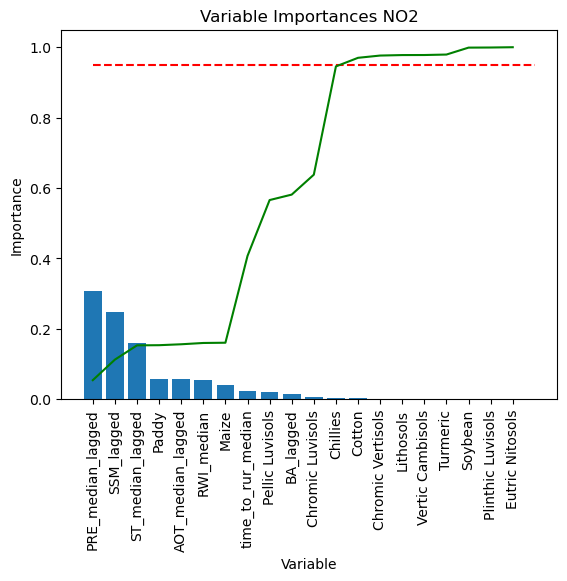

In [123]:
names_NO2=[]
values_NO2=[]
for i in range(0, len(importances_NO2)):
    names_NO2.append(feature_importances_NO2[i][0])
    values_NO2.append(feature_importances_NO2[i][1])


plt.bar(names_NO2, values_NO2)
# Cumulative importances
cumulative_importances = np.cumsum(importances_NO2)
# Make a line graph
plt.plot(names_NO2, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(importances_NO2), color = 'r', linestyles = 'dashed')
plt.xticks(names_NO2, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances NO2')
plt.show()

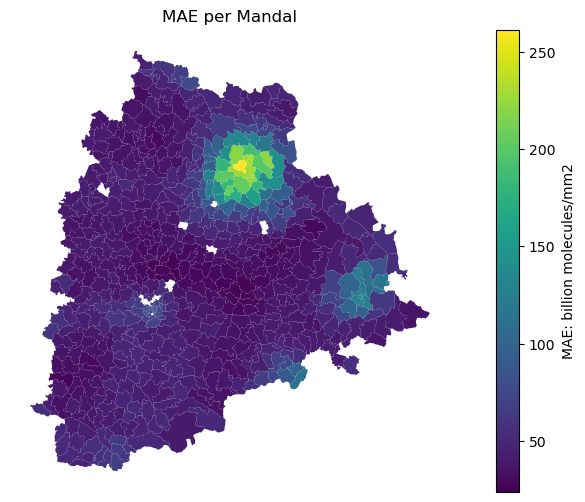

In [125]:
data['Predictions NO2'] = clf_NO2.predict(data[optimal_features_NO2])
data['Errors NO2'] = abs(data['Predictions NO2'] - data['NO2'])

mandal_errors = data.groupby(['index'])['Errors NO2'].mean().reset_index()
mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

mandal_errors.plot(column = 'Errors NO2', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: billion molecules/mm2'}, )
plt.axis('off')
plt.title('MAE per Mandal')
plt.show()

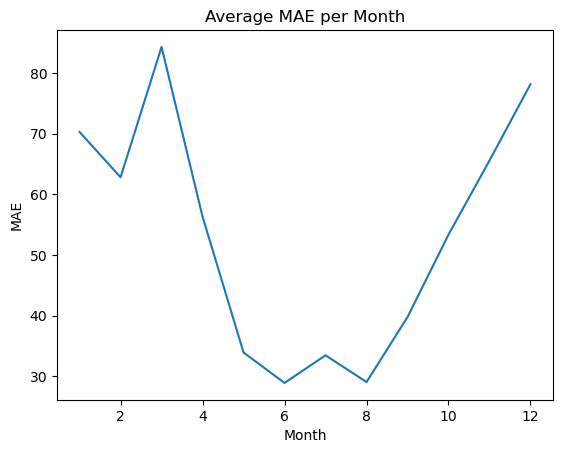

In [126]:
errors_per_month = data.groupby('Month')['Errors NO2'].mean().reset_index()

plt.plot(errors_per_month['Month'], errors_per_month['Errors NO2'])
plt.xlabel('Month')
plt.ylabel('MAE')
plt.title('Average MAE per Month')
plt.show()

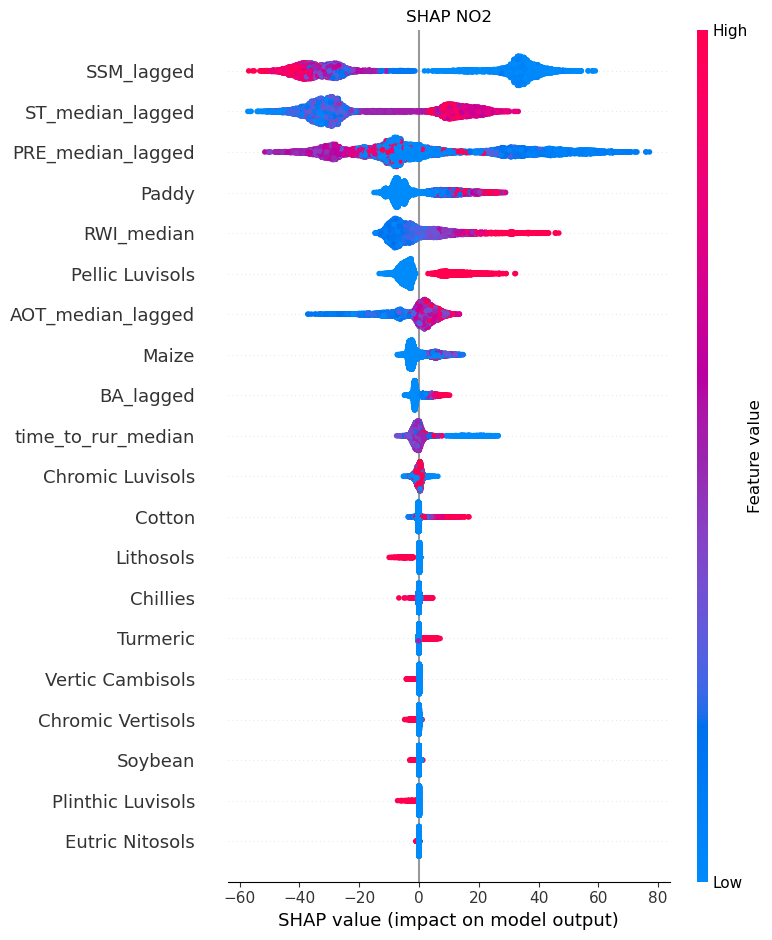

In [52]:
#SHAP
rfe_NO2 = shap.TreeExplainer(clf_NO2)
shap_values_rf_test_NO2 = rfe_NO2.shap_values(test[optimal_features_NO2])
shap_values_rf_train_NO2 = rfe_NO2.shap_values(train[optimal_features_NO2])

plt.title('SHAP NO2')
shap.summary_plot(shap_values_rf_train_NO2, train[optimal_features_NO2])

In [31]:
#shap.dependence_plot('Turmeric', shap_values_rf_train_NO2, train[optimal_features_NO2])

PM2.5

In [149]:
array_X = np.array(data[optimal_features_PM25])
array_Y = np.array(data[predictors[1]])

cv = BlockingTimeSeriesSplit(n_splits = k_fold)

for train_index, test_index in cv.split(array_X):
    MAE_folds = []
    R2_folds = []
    RMSE_folds = []
    accuracy_folds = []
    
    #print('TRAIN:', train_index, 'TEST', test_index) 
    x_train, x_test = array_X[train_index], array_X[test_index]
    y_train, y_test = array_Y[train_index], array_Y[test_index]

    #max_features_optimal = int(len(optimal_features_PM25)/3)
    #if max_features_optimal == 0:
    #    max_features_optimal=1

    clf_PM25 = RandomForestRegressor(n_estimators=n_estimators_PM25, max_depth=max_depth_PM25, bootstrap = bootstrap_PM25, max_features = 'auto', min_samples_leaf = min_samples_leaf_PM25, min_samples_split = min_samples_split_PM25, criterion='mse')

    #Fit to the training data
    clf_PM25.fit(x_train, y_train)

    #Make a prediction on the test data
    predictions = clf_PM25.predict(x_test)

    #Calculate mean absolute error
    MAE_folds.append(mean_absolute_error(y_test, predictions))

    #MAPE
    errors = abs(predictions - y_test)
    mape = 100 * (errors / y_test)

    # Calculate and display accuracy
    accuracy_folds.append(100 - np.mean(mape))

    #RMSE
    MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
    RMSE_folds.append(math.sqrt(MSE_folds))

    #R2
    R2_folds.append(r2_score(y_test, predictions))
    

MAE = sum(MAE_folds)/len(MAE_folds)
RMSE = sum(RMSE_folds)/len(RMSE_folds)
R2 = sum(R2_folds)/len(R2_folds)
Accuracy = sum(accuracy_folds)/len(accuracy_folds)

In [150]:
print('MAE: ' + str(MAE))
print('RMSE: ' + str(RMSE))
print('R2: ' + str(R2))
print('Accuracy: ' + str(Accuracy))

MAE: 11.541209522367737
RMSE: 14.524197806439544
R2: -1.3670068851682027
Accuracy: 73.65217493316179


In [151]:
importances_PM25 = list(clf_PM25.feature_importances_)
feature_importances_PM25 = [(feature, round(importance, 15)) for feature, importance in zip(optimal_features_PM25, importances_PM25)]
feature_importances_PM25 = sorted(feature_importances_PM25, key = lambda x: x[1], reverse = True)
feature_importances_PM25

[('PRE_median_lagged', 0.861365798914836),
 ('ST_median_lagged', 0.05158002341241),
 ('Pellic Luvisols', 0.034504704585093),
 ('time_to_rur_median', 0.026063079337055),
 ('AOT_median_lagged', 0.02014365352122),
 ('BA_lagged', 0.003136794330135),
 ('Chromic Luvisols', 0.001361230191228),
 ('Eutric Nitosols', 0.001144747421947),
 ('Lithosols', 0.000366090937535),
 ('Chromic Vertisols', 0.000190142946514),
 ('Vertic Cambisols', 0.000143734402026),
 ('Plinthic Luvisols', 0.0)]

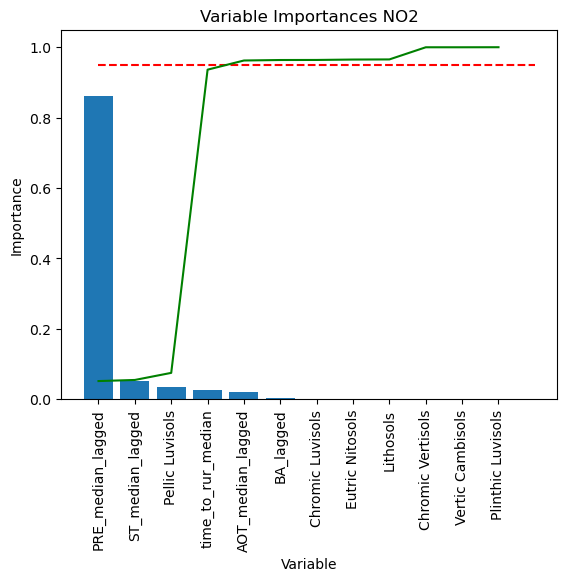

In [152]:
names_PM25=[]
values_PM25=[]
for i in range(0, len(importances_PM25)):
    names_PM25.append(feature_importances_PM25[i][0])
    values_PM25.append(feature_importances_PM25[i][1])


plt.bar(names_PM25, values_PM25)
# Cumulative importances
cumulative_importances = np.cumsum(importances_PM25)
# Make a line graph
plt.plot(names_PM25, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(importances_PM25), color = 'r', linestyles = 'dashed')
plt.xticks(names_PM25, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances NO2')
plt.show()

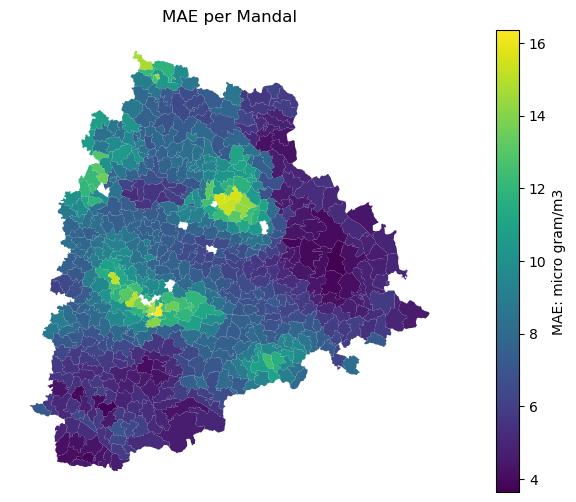

In [153]:
data['Predictions PM2.5'] = clf_PM25.predict(data[optimal_features_PM25])
data['Errors PM2.5'] = abs(data['Predictions PM2.5'] - data['PM2.5'])

mandal_errors = data.groupby(['index'])['Errors PM2.5'].mean().reset_index()
mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

mandal_errors.plot(column = 'Errors PM2.5', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: micro gram/m3'}, )
plt.axis('off')
plt.title('MAE per Mandal')
plt.show()

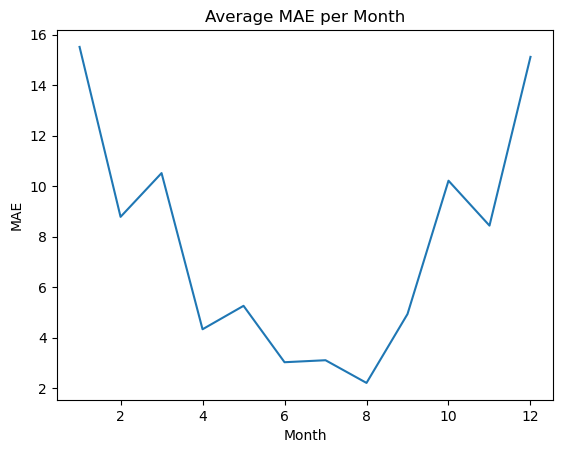

In [154]:
errors_per_month = data.groupby('Month')['Errors PM2.5'].mean().reset_index()

plt.plot(errors_per_month['Month'], errors_per_month['Errors PM2.5'])
plt.xlabel('Month')
plt.ylabel('MAE')
plt.title('Average MAE per Month')
plt.show()

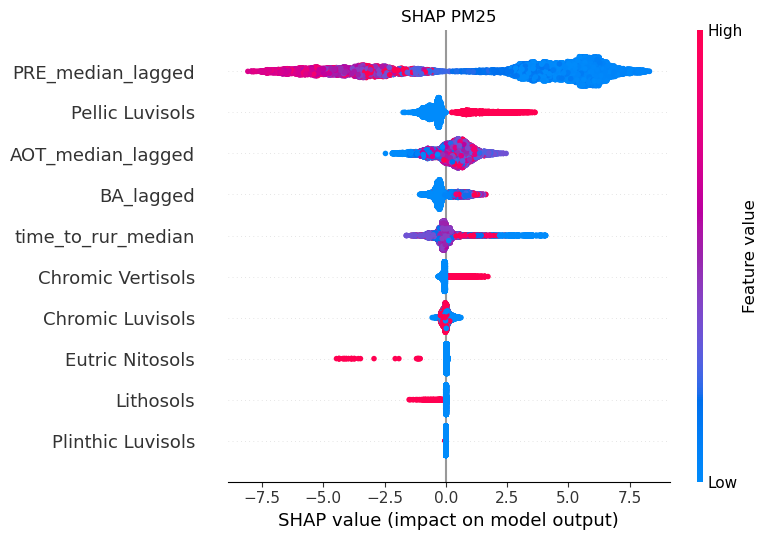

In [81]:
#SHAP
rfe_PM25 = shap.TreeExplainer(clf_PM25)
shap_values_rf_test_PM25 = rfe_PM25.shap_values(test[optimal_features_PM25])
shap_values_rf_train_PM25 = rfe_PM25.shap_values(train[optimal_features_PM25])

plt.title('SHAP PM25')
shap.summary_plot(shap_values_rf_train_PM25, train[optimal_features_PM25])